In [108]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_plotting = os.path.join(folder_AGVA, 'Plotting')

# # open rgi
# path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
# rgi_gdf = gpd.read_file(path_rgi)

# # subset rgi to glacier bigger than 2km, not the brooks range
# rgi_gdf = rgi_gdf[rgi_gdf['Area']>=2]
# rgi_gdf = rgi_gdf[rgi_gdf['O2Region']!="1"]

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi)
print(rgi_gdf.crs)

EPSG:3338


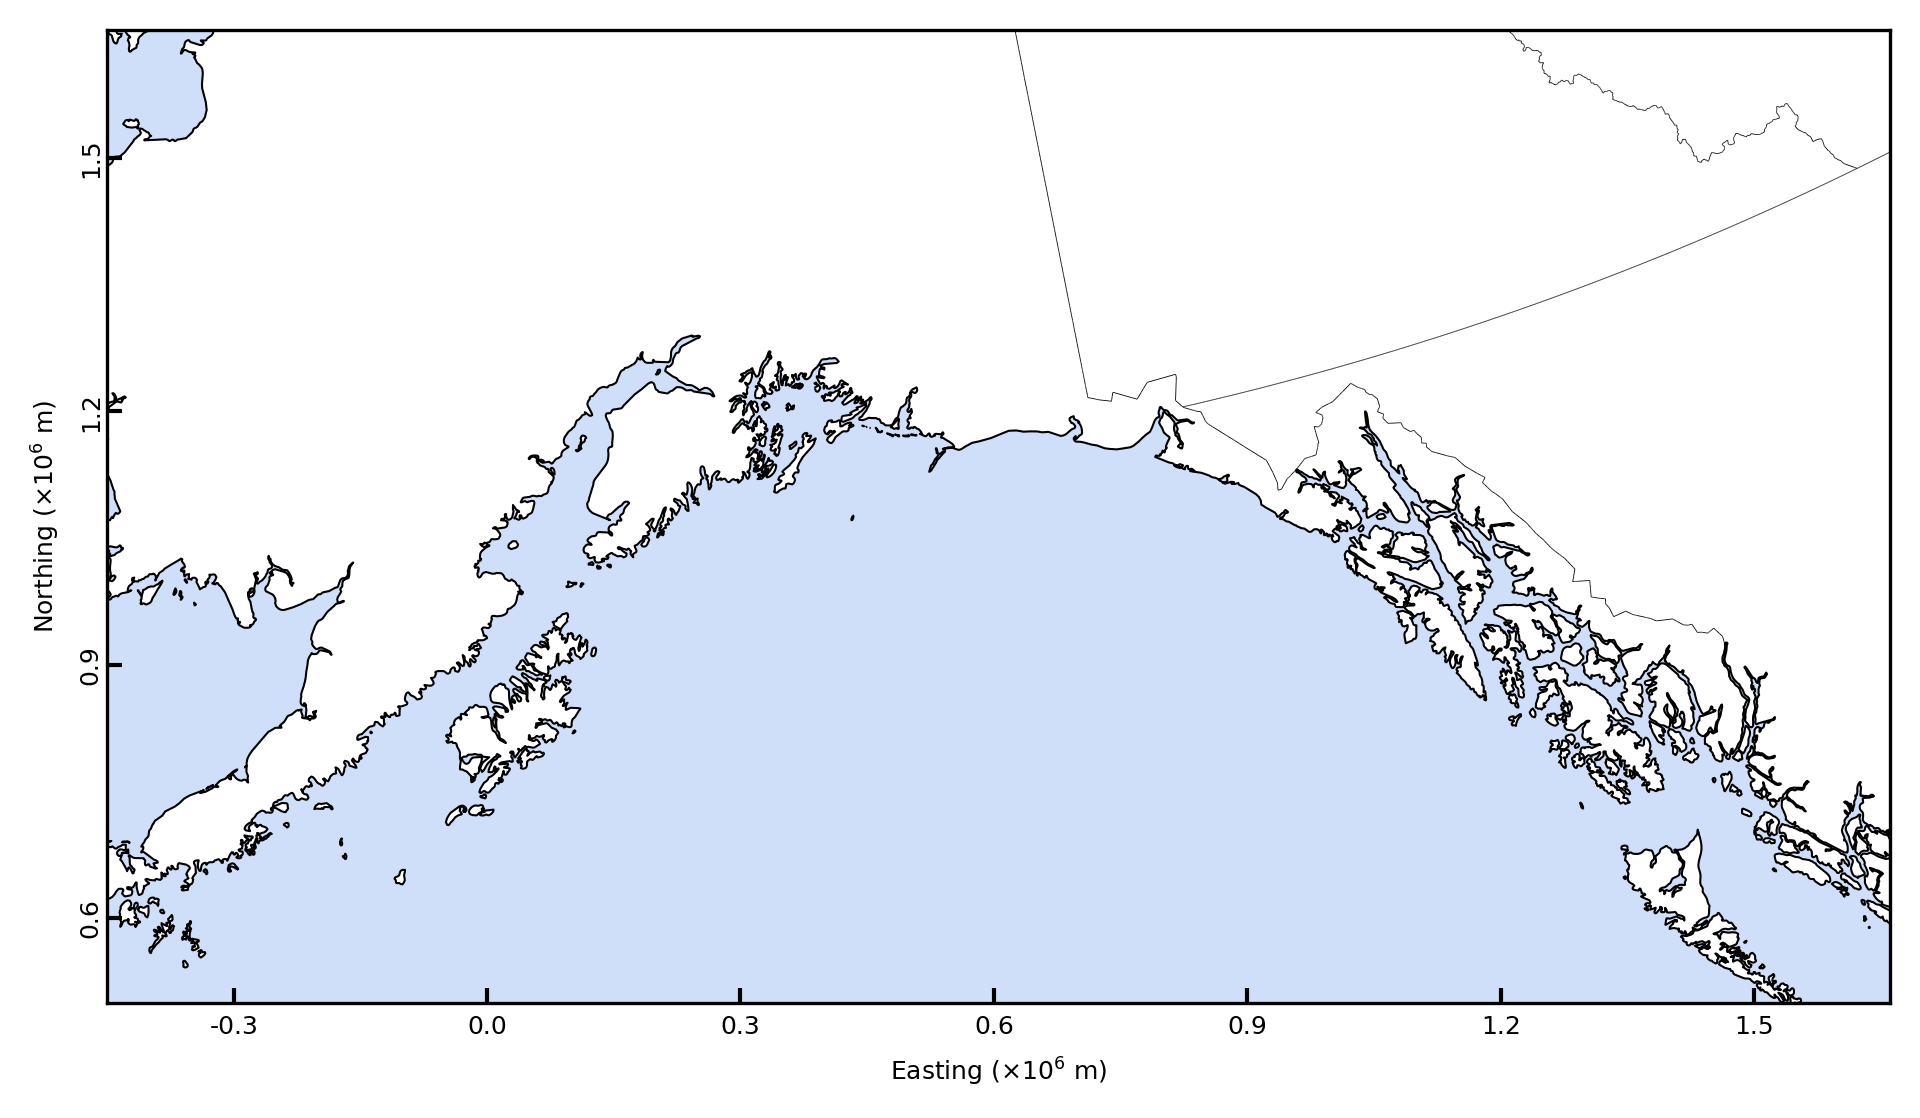

In [2]:
fig,axs = snowFun.create_base_map(hillshade=0)

EPSG:4326


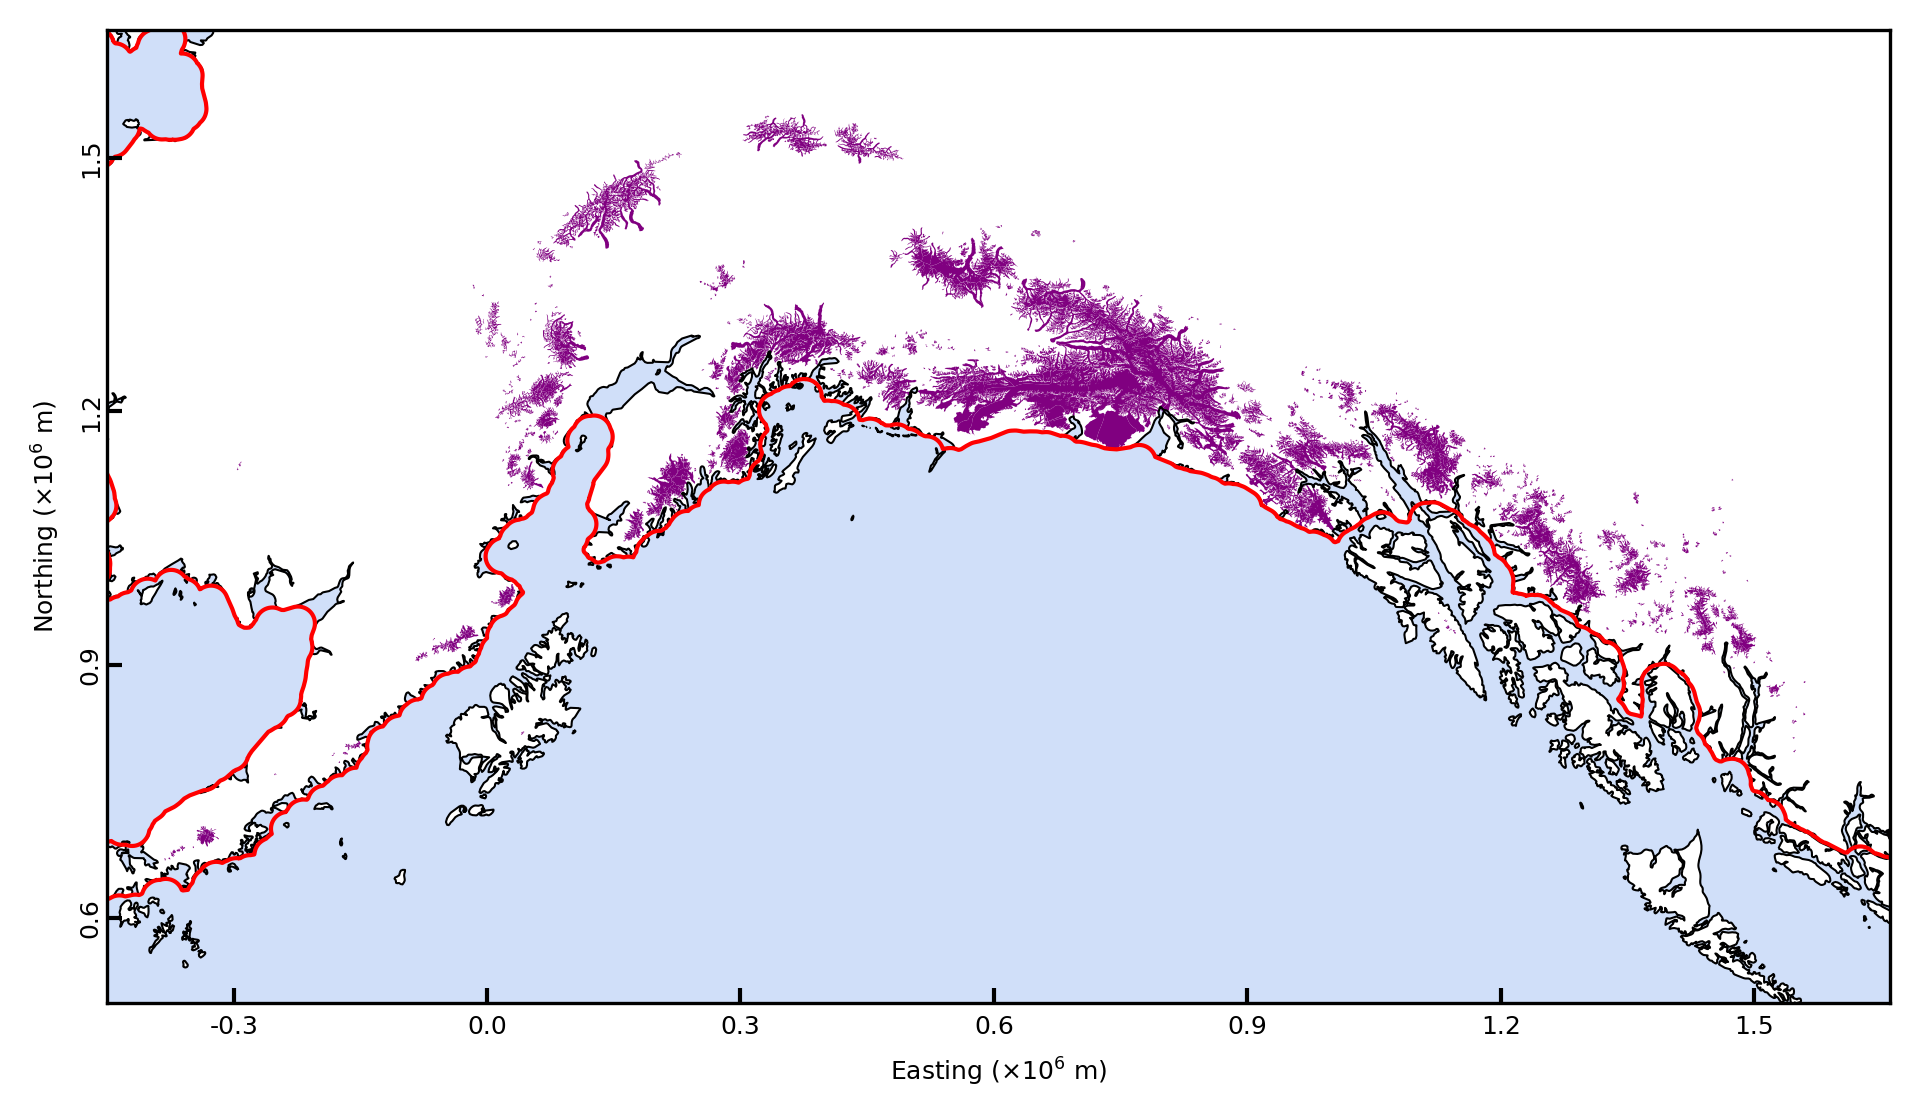

In [112]:
### lets try making a distance-from-coast product
from shapely.geometry import Polygon, MultiPolygon

# open ocean shapefile
folder_plotting = os.path.join(folder_AGVA, 'Plotting')
path_ocean = os.path.join(folder_plotting, 'ne_10m_ocean', 'ne_10m_ocean.shp')
ocean = gpd.read_file(path_ocean)
ocean_orig = ocean.copy().to_crs("EPSG:3338")

# simplify ocean shapefile by filling holes
new_geom = []
for polygon in ocean.geometry.values[0].geoms:
    list_interiors = []
    for interior in polygon.interiors:
        if Polygon(interior).area > 5:
            list_interiors.append(interior)
    new_geom.append(Polygon(polygon.exterior.coords, holes=list_interiors))
ocean['geometry'] = [MultiPolygon(new_geom)]
ocean = ocean.to_crs("EPSG:3338")

# further simplify by buffer in then out
ocean_smooth = ocean.buffer(-20000).buffer(20000)
# ocean_smooth2 = ocean.buffer(-20000).buffer(20000)
# ocean_smooth = ocean.simplify(10000)

# ranges and ticks
xlims = (-450000, 1661000)
ylims = (500000, 1652000)
xticks = np.arange(-300000,1500001,300000)
yticks = np.arange(600000,1500001,300000)
xtick_labels = xticks/1000000
ytick_labels = yticks/1000000

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,5), dpi=300)

ocean_orig.plot(ax=axs, color='cornflowerblue', alpha=0.3, zorder=1.2)
ocean_orig.boundary.plot(ax=axs, color='black', linewidth=0.5, alpha=1, zorder=1.35)
ocean_smooth.boundary.plot(ax=axs, color='red', linewidth=1, alpha=1, zorder=1.35)
# ocean_smooth2.boundary.plot(ax=axs, color='yellow', linewidth=1, alpha=1, zorder=1.35)
rgi_gdf.plot(ax=axs, color='purple')

# set axis limits
axs.set_xlim(xlims)
axs.set_ylim(ylims)

# set axis ticks, format marks inwards
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xtick_labels)
axs.set_yticklabels(ytick_labels, rotation=90, va='center')
axs.tick_params(axis="x", pad=3, direction="in", width=1, labelsize=6, zorder=2)
axs.tick_params(axis="y" ,pad=1, direction="in", width=1, labelsize=6, zorder=2)

# set axis labels
axs.set_xlabel(r'Easting ($ \times 10^6$ m)', size=6)
axs.set_ylabel(r'Northing ($ \times 10^6$ m)', size=6)
plt.title("")

plt.tight_layout()

In [140]:
### calculate distance between glacier centroid and this product

# format to points
all_points = gpd.points_from_xy(rgi_gdf['CenLon'], rgi_gdf['CenLat'], z=None, crs="EPSG:4326").to_crs("EPSG:3338")

# to store info
all_rgis = []
all_distances = []

# loop through each point
for i, point in enumerate(all_points):
    
    # calculate distance to ocean
    dist = point.distance(ocean.geometry).values[0]/1000
    
    # if distance is 0, recalculate using the un-smoothed ocean boundary
    if dist==0:
        dist = point.distance(ocean_orig.geometry).values[0]/1000
        
    # append data
    all_distances.append(dist)
    all_rgis.append(rgi_gdf['RGIId'].values[i])
    
# format to gdf
distances_df = gpd.GeoDataFrame({"RGIId":all_rgis, "Distance":all_distances, 'geometry':all_points}, crs='EPSG:3338')

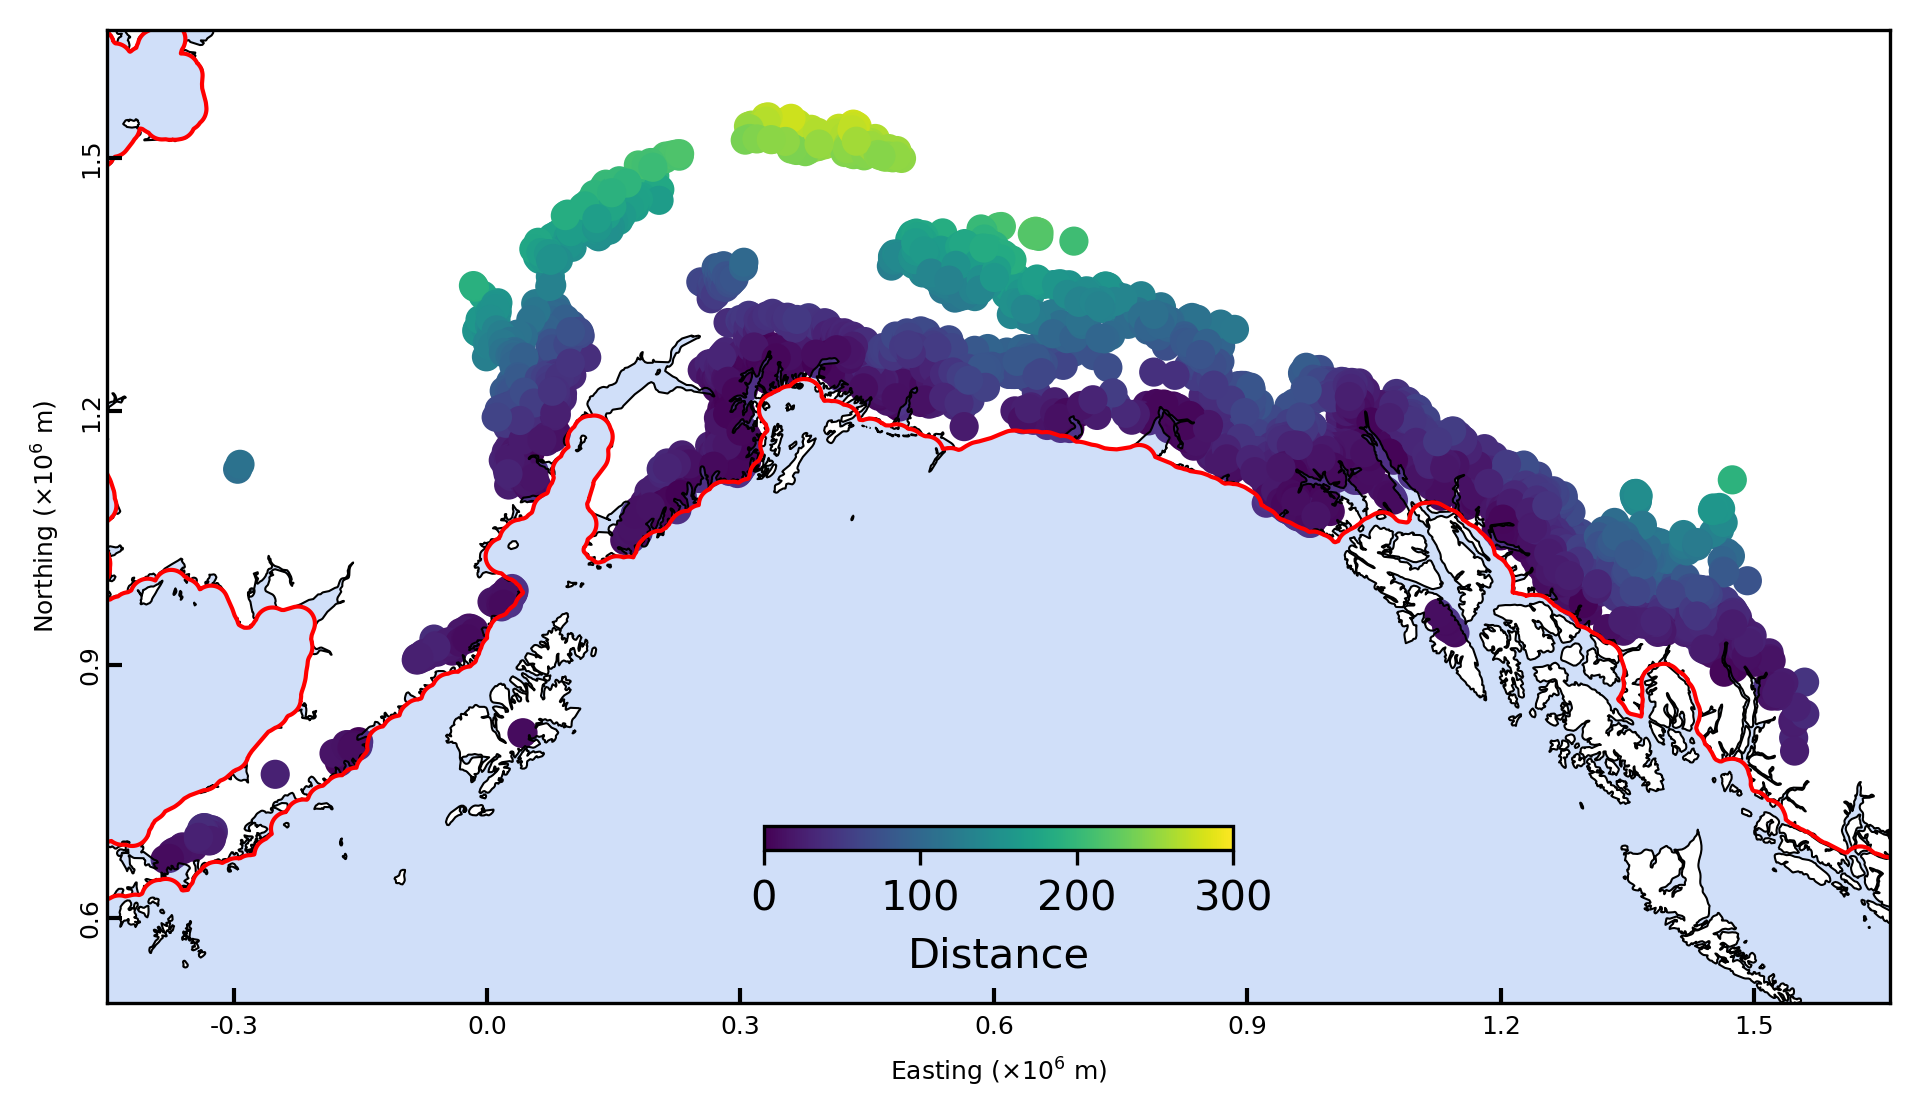

In [143]:
# initiate figure
fig,axs = plt.subplots(figsize=(6.5,5), dpi=300)

ocean_orig.plot(ax=axs, color='cornflowerblue', alpha=0.3, zorder=1.2)
ocean_orig.boundary.plot(ax=axs, color='black', linewidth=0.5, alpha=1, zorder=1.35)
ocean_smooth.boundary.plot(ax=axs, color='red', linewidth=1, alpha=1, zorder=1.35)

distances_df.plot(ax=axs, column='Distance', legend=True, vmin=0, vmax=300,
                          legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15, "label":'Distance'})
# rgi_gdf.plot(ax=axs, color='purple')

# set axis limits
axs.set_xlim(xlims)
axs.set_ylim(ylims)

# set axis ticks, format marks inwards
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xtick_labels)
axs.set_yticklabels(ytick_labels, rotation=90, va='center')
axs.tick_params(axis="x", pad=3, direction="in", width=1, labelsize=6, zorder=2)
axs.tick_params(axis="y" ,pad=1, direction="in", width=1, labelsize=6, zorder=2)

# set axis labels
axs.set_xlabel(r'Easting ($ \times 10^6$ m)', size=6)
axs.set_ylabel(r'Northing ($ \times 10^6$ m)', size=6)
plt.title("")

plt.tight_layout()

In [134]:
distances_df

RGIId       Distance                         geometry
0     RGI60-01.00004  249190.655661   POINT (392263.559 1513642.241)
1     RGI60-01.00005  255384.857654   POINT (343819.769 1527323.269)
2     RGI60-01.00006  267314.636748   POINT (383645.938 1533996.585)
3     RGI60-01.00010  249051.450100   POINT (338679.670 1522520.530)
4     RGI60-01.00012  239802.162306   POINT (366127.551 1508945.429)
...              ...            ...                              ...
3026  RGI60-01.27103   48138.389012  POINT (1125399.610 1164111.781)
3027  RGI60-01.27105   25532.954200  POINT (1281397.905 1005688.012)
3028  RGI60-01.27106   41115.373119   POINT (814397.583 1242694.587)
3029  RGI60-01.27108   21391.329580   POINT (564811.165 1181980.087)
3030  RGI60-01.27110   23920.358063   POINT (1548026.937 797824.924)

[3031 rows x 3 columns]

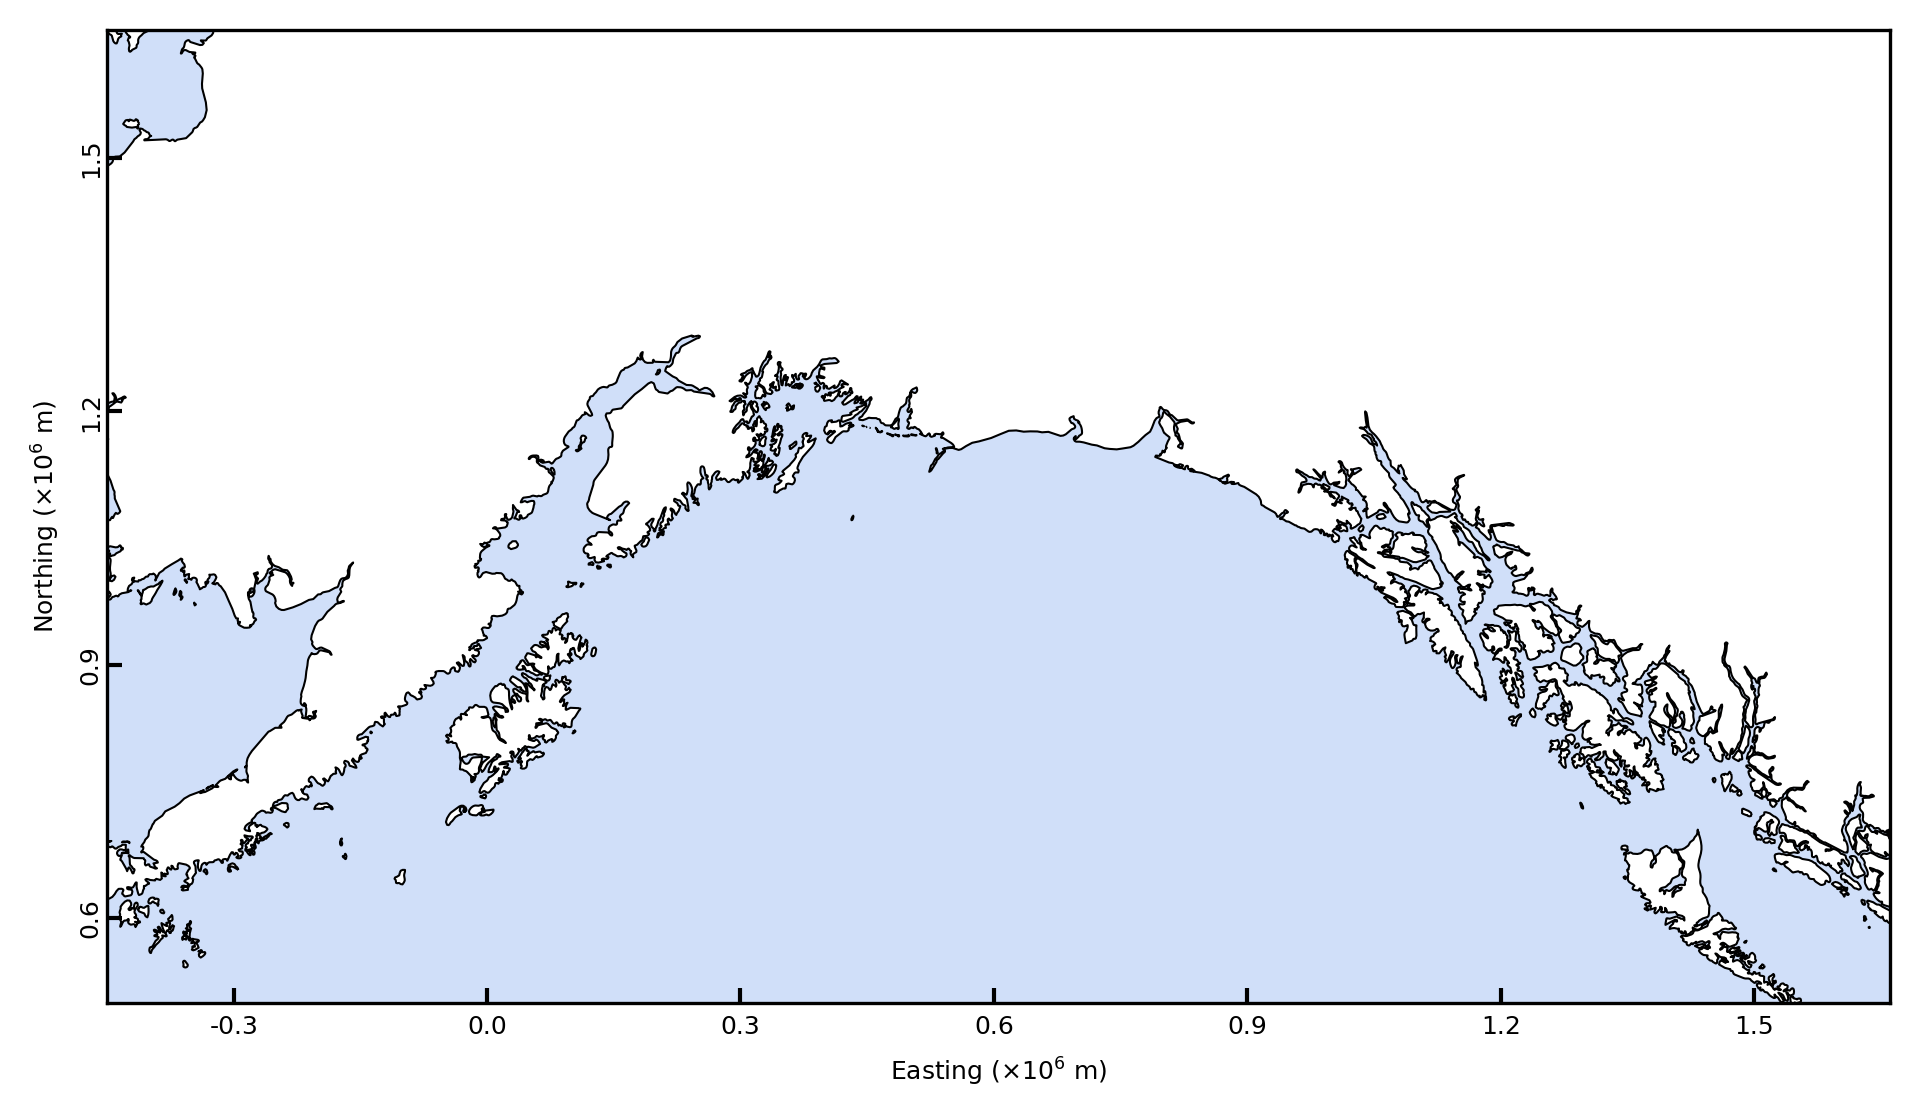

In [7]:
### lets try making a distance-from-coast product

# open ocean shapefile
folder_plotting = os.path.join(folder_AGVA, 'Plotting')
path_ocean = os.path.join(folder_plotting, 'ne_10m_ocean', 'ne_10m_ocean.shp')
ocean = gpd.read_file(path_ocean).to_crs("EPSG:3338")

# ranges and ticks
xlims = (-450000, 1661000)
ylims = (500000, 1652000)
xticks = np.arange(-300000,1500001,300000)
yticks = np.arange(600000,1500001,300000)
xtick_labels = xticks/1000000
ytick_labels = yticks/1000000

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,5), dpi=300)

ocean.plot(ax=axs, color='cornflowerblue', alpha=0.3, zorder=1.2)
ocean.boundary.plot(ax=axs, color='black', linewidth=0.5, alpha=1, zorder=1.35)

# set axis limits
axs.set_xlim(xlims)
axs.set_ylim(ylims)

# set axis ticks, format marks inwards
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xtick_labels)
axs.set_yticklabels(ytick_labels, rotation=90, va='center')
axs.tick_params(axis="x", pad=3, direction="in", width=1, labelsize=6, zorder=2)
axs.tick_params(axis="y" ,pad=1, direction="in", width=1, labelsize=6, zorder=2)

# set axis labels
axs.set_xlabel(r'Easting ($ \times 10^6$ m)', size=6)
axs.set_ylabel(r'Northing ($ \times 10^6$ m)', size=6)
plt.title("")

plt.tight_layout()

In [3]:
# define paths to shapefiles and background images
# path_ne = os.path.join(folder_plotting, 'NE1_50M_SR_W', 'NE1_50M_SR_W_AA_clipped.tif')
# path_ne = os.path.join(folder_plotting, 'NE1_HR_LC_SR_W', 'NE1_HR_LC_SR_W_AA_clipped_resample.tif')
path_ne = os.path.join(folder_plotting, 'GRAY_HR_SR_OB', 'GRAY_HR_SR_OB_AA_500m.tif') 
# path_ne = os.path.join(folder_plotting, 'SR_HR', 'SR_HR_AA_500m.tif') 
path_usa_bound = os.path.join(folder_plotting, 'gadm41_USA_shp', 'gadm41_USA_1.shp')
path_can_bound = os.path.join(folder_plotting, 'gadm41_CAN_shp', 'gadm41_CAN_1.shp')

# open with xr and gpd
ne_background = riox.open_rasterio(path_ne)
bound_usa = gpd.read_file(path_usa_bound)
bound_can = gpd.read_file(path_can_bound)

# subset outlines to alaska, yukon, bc
bound_usa = bound_usa[bound_usa['NAME_1']=='Alaska']
bound_can = bound_can[bound_can['NAME_1'].isin(['Yukon', 'British Columbia', 'Northwest Territories'])]

# reproject outlines to alaska albers
bound_usa = bound_usa.to_crs("EPSG:3338")
bound_can = bound_can.to_crs("EPSG:3338")

# reproject rgi to alaska albers
rgi_gdf = rgi_gdf.to_crs("EPSG:3338")

# format usa/canada boundaries. this keep only a single copy of the boundaries between states/territories
line1 = gpd.overlay(bound_usa, bound_can, keep_geom_type=False, how='intersection')
line2 = gpd.overlay(bound_can[bound_can["NAME_1"]=='Yukon'], bound_can[bound_can["NAME_1"]=='Northwest Territories'], keep_geom_type=False, how='intersection')
line3 = gpd.overlay(bound_can[bound_can["NAME_1"]=='Yukon'], bound_can[bound_can["NAME_1"]=='British Columbia'], keep_geom_type=False, how='intersection')
line4 = gpd.overlay(bound_can[bound_can["NAME_1"]=='British Columbia'], bound_can[bound_can["NAME_1"]=='Northwest Territories'], keep_geom_type=False, how='intersection')
boundary_lines = pd.concat([line1, line2, line3, line4])
# boundary_lines.to_file(os.path.join(folder_plotting, "usa_can_boundaries", "boundary_lines.shp"))

# open ocean shapefile
path_ocean = os.path.join(folder_plotting, 'ne_10m_ocean', 'ne_10m_ocean.shp')
ocean = gpd.read_file(path_ocean).to_crs("EPSG:3338")

# define the extent of the plots.
plot_buffer = 100000
plot_bounds = rgi_gdf.geometry.total_bounds
xlims = ( int(plot_bounds[0]-plot_buffer) , int(plot_bounds[2]+plot_buffer) )
ylims = ( int(plot_bounds[1]-plot_buffer) , int(plot_bounds[3]+plot_buffer) )

# manual override because I want to cut out some of the alaska peninsula
xlims = (-450000, 1661000)
ylims = (500000, 1652000)

# define what the x and y ticks are going to be
xticks = np.arange(-300000,1500001,300000)
yticks = np.arange(600000,1500001,300000)
xtick_labels = xticks/1000000
ytick_labels = yticks/1000000

# create non-ocean (land) geometry
not_ocean = box(*box(xlims[0], ylims[0], xlims[1], ylims[1]).buffer(50000).bounds)
not_ocean = not_ocean.difference(ocean["geometry"].values[0])
not_ocean = gpd.GeoSeries( [not_ocean], crs=ocean.crs )

# subset background to the defined limits
ne_background = ne_background.sel(x=slice(xlims[0]-5000, xlims[1]+5000),
                                  y=slice(ylims[1]+5000, ylims[0]-5000))

C:\Users\lzell\AppData\Local\Temp\ipykernel_11496\3468489627.py:31: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  boundary_lines.to_file(os.path.join(folder_plotting, "usa_can_boundaries", "boundary_lines.shp"))


### Example study area plot

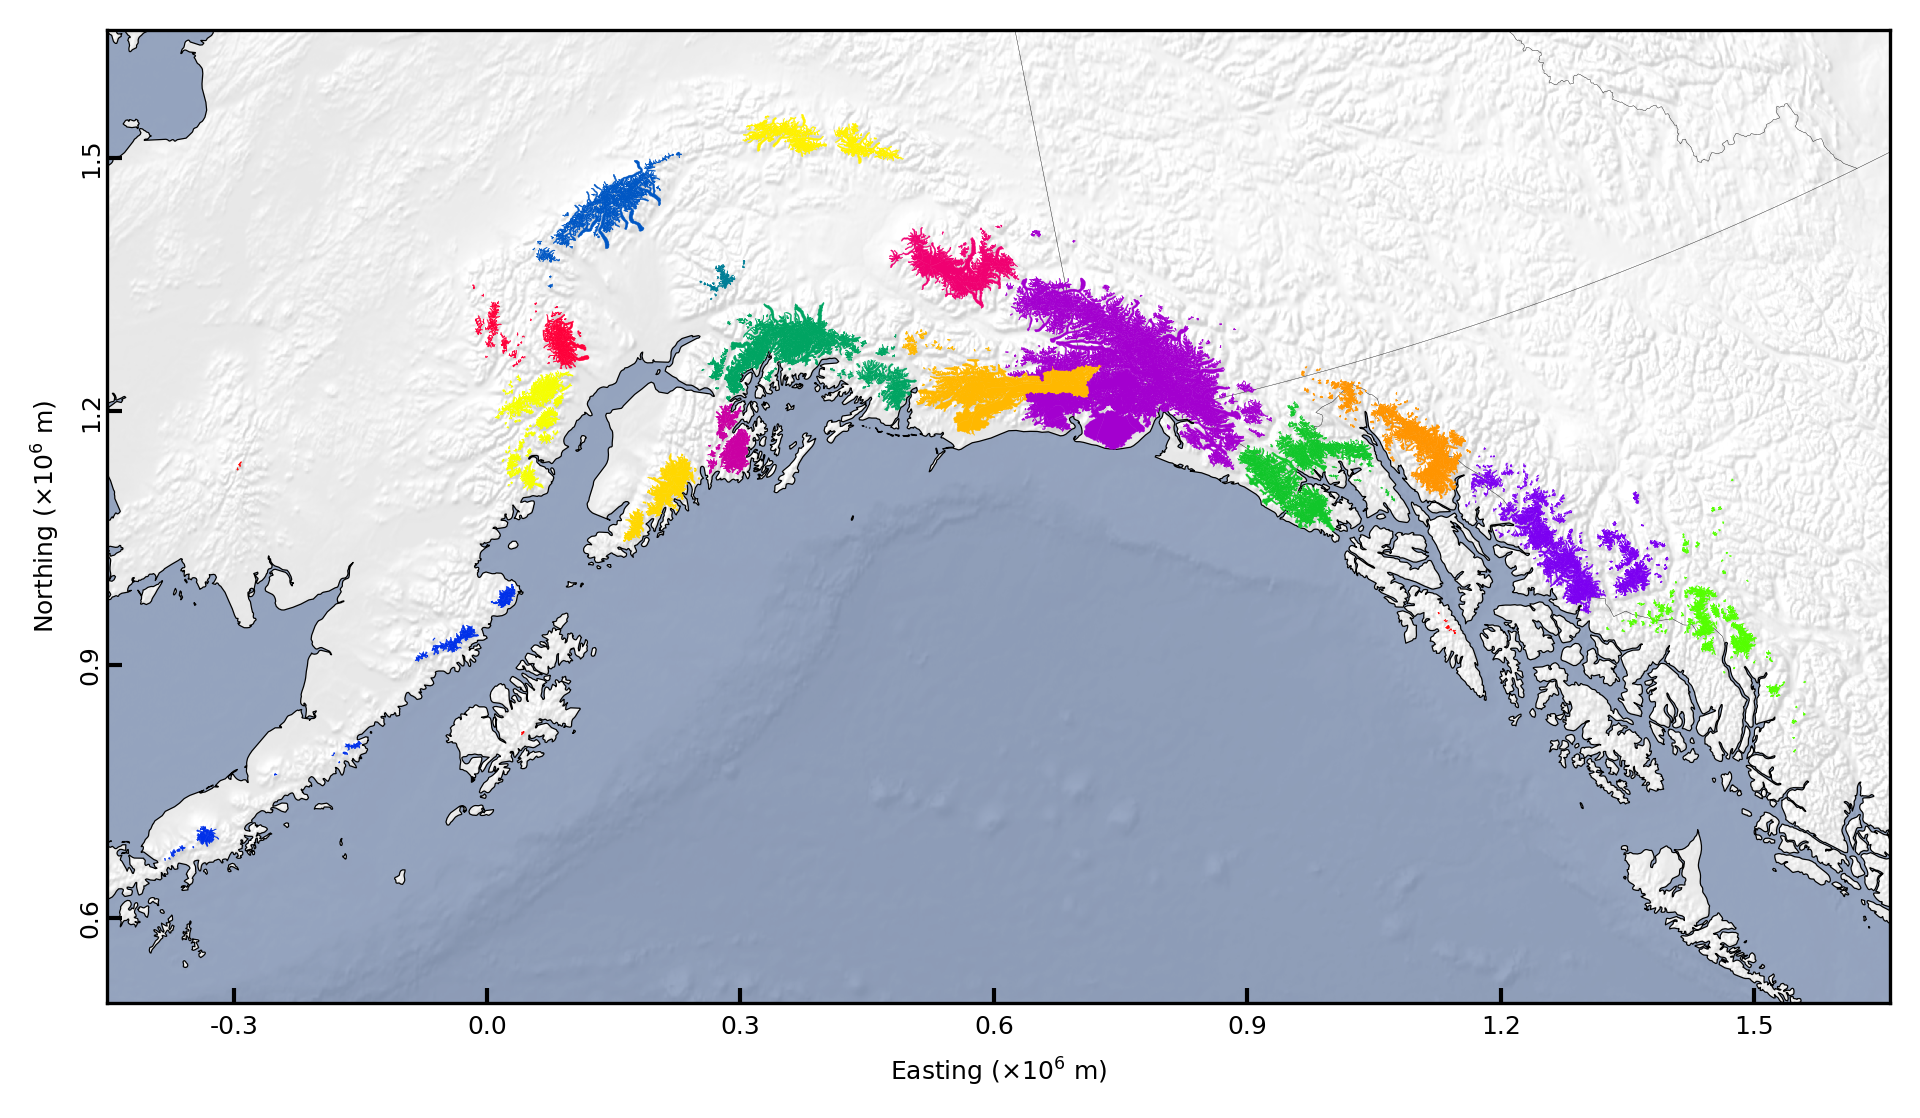

In [10]:
# initiate figure
fig,axs = plt.subplots(figsize=(6.5,5), dpi=300)

# add background hillshade
ne_background.plot(ax=axs, cmap='gray', vmin=-100, vmax=200, add_colorbar=False, zorder=1)

# add colored shapes overlaying the ocean and land
ocean.plot(ax=axs, color='cornflowerblue', alpha=0.3, zorder=1.2)
not_ocean.plot(ax=axs, color='white', alpha=0.5, zorder=1.3)

# add usa and canada boundaries
boundary_lines.plot(ax=axs, color='black', linewidth=0.1, zorder=1.4)

# add ocean boundary outline
not_ocean.boundary.plot(ax=axs, color='black', linewidth=0.3, alpha=1, zorder=1.35)

# add rgi outlines
rgi_gdf.plot(ax=axs, column='O3Region', edgecolor='face', linewidth=0.1, cmap='prism', zorder=1.5)

# set axis limits
axs.set_xlim(xlims)
axs.set_ylim(ylims)

# set axis ticks, format marks inwards
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xtick_labels)
axs.set_yticklabels(ytick_labels, rotation=90, va='center')
axs.tick_params(axis="x", pad=3, direction="in", width=1, labelsize=6, zorder=2)
axs.tick_params(axis="y" ,pad=1, direction="in", width=1, labelsize=6, zorder=2)

# set axis labels
axs.set_xlabel(r'Easting ($ \times 10^6$ m)', size=6)
axs.set_ylabel(r'Northing ($ \times 10^6$ m)', size=6)
plt.title("")

plt.tight_layout()

### Quicker option that doesn't include background hillshade

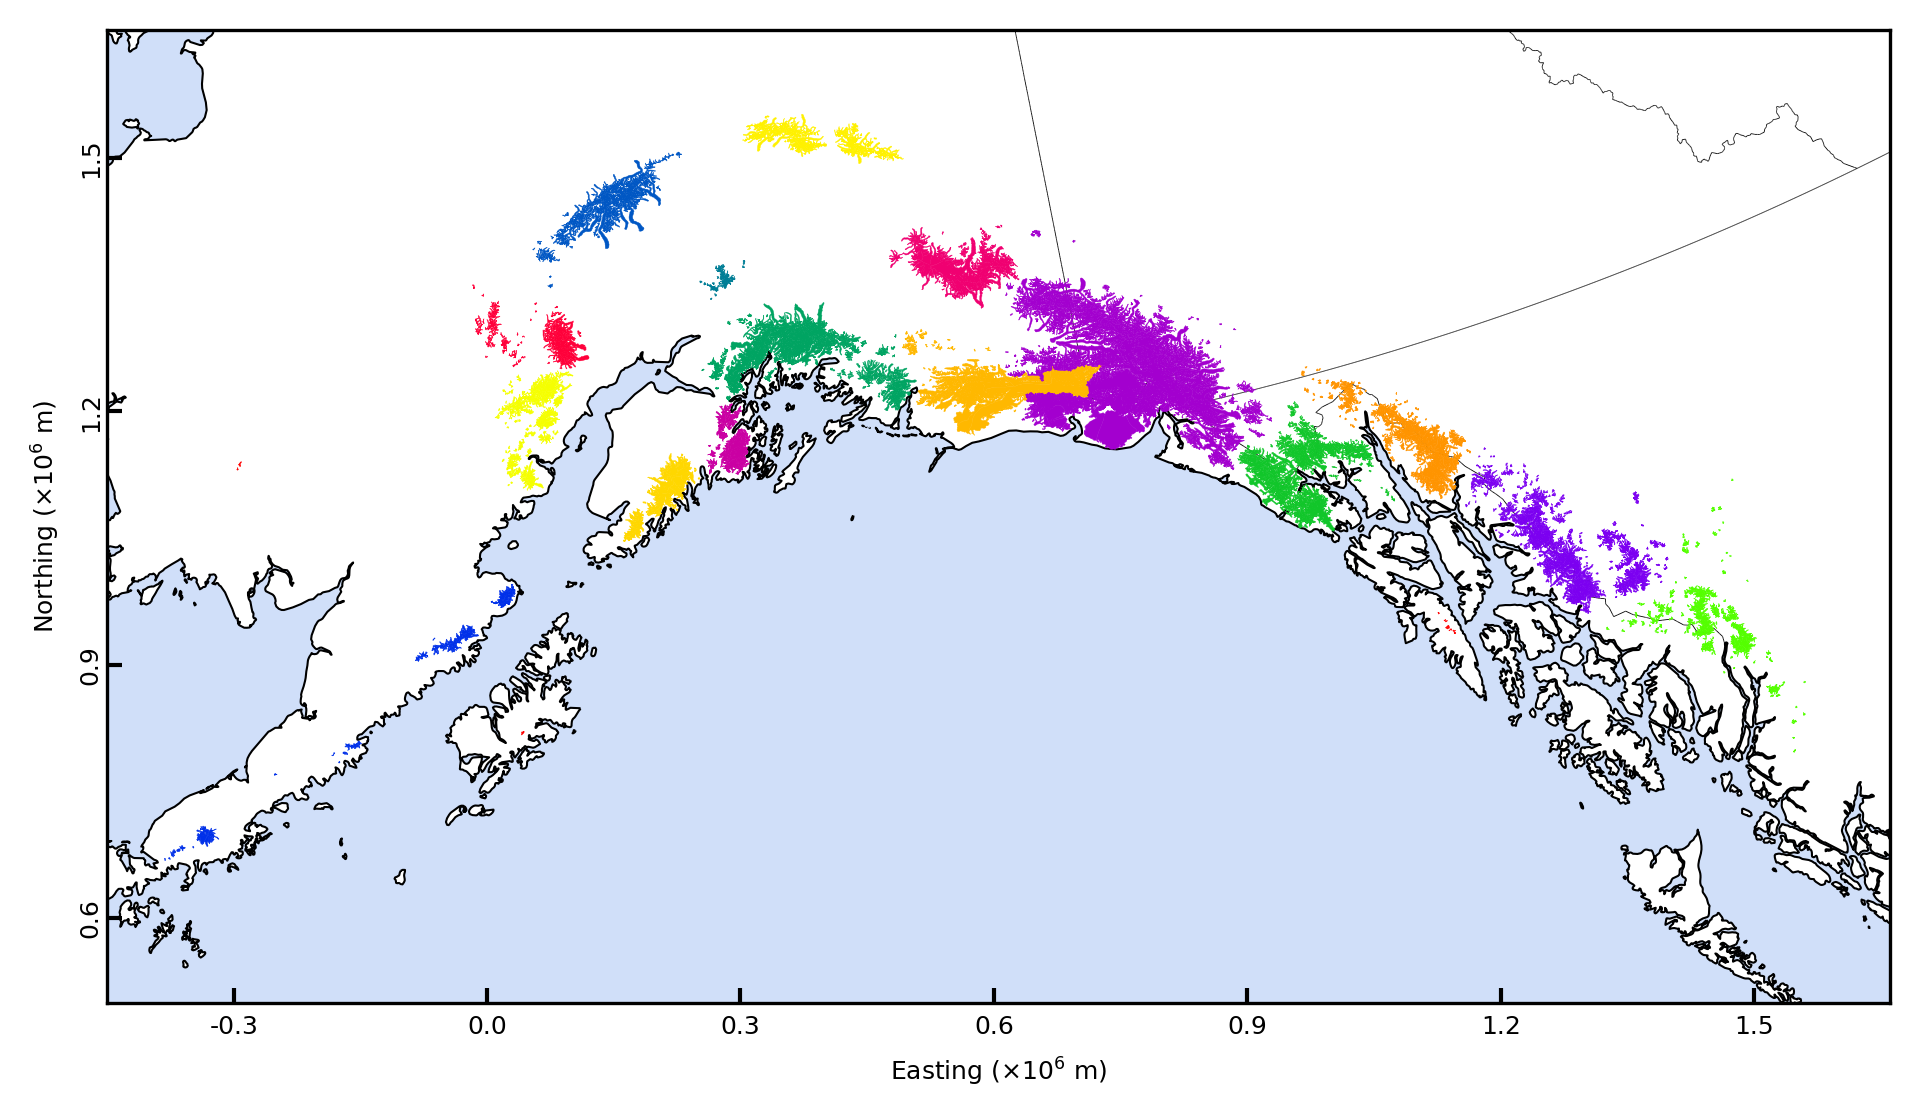

In [9]:
# initiate figure
fig,axs = plt.subplots(figsize=(6.5,5), dpi=300)

# add background hillshade
# ne_background.plot(ax=axs, cmap='gray', vmin=-100, vmax=200, add_colorbar=False, zorder=1)

# add colored shapes overlaying the ocean and land
ocean.plot(ax=axs, color='cornflowerblue', alpha=0.3, zorder=1.2)
not_ocean.plot(ax=axs, color='white', alpha=0.5, zorder=1.3)

# add usa and canada boundaries
boundary_lines.plot(ax=axs, color='black', linewidth=0.2, zorder=1.4)

# add ocean boundary outline
not_ocean.boundary.plot(ax=axs, color='black', linewidth=0.5, alpha=1, zorder=1.35)

# add rgi outlines
rgi_gdf.plot(ax=axs, column='O3Region', edgecolor='face', linewidth=0.1, cmap='prism', zorder=1.5)

# set axis limits
axs.set_xlim(xlims)
axs.set_ylim(ylims)

# set axis ticks, format marks inwards
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xtick_labels)
axs.set_yticklabels(ytick_labels, rotation=90, va='center')
axs.tick_params(axis="x", pad=3, direction="in", width=1, labelsize=6, zorder=2)
axs.tick_params(axis="y" ,pad=1, direction="in", width=1, labelsize=6, zorder=2)

# set axis labels
axs.set_xlabel(r'Easting ($ \times 10^6$ m)', size=6)
axs.set_ylabel(r'Northing ($ \times 10^6$ m)', size=6)
plt.title("")

plt.tight_layout()